<a href="https://colab.research.google.com/github/lelenzasan/Projeto_Tarifa_Zero_Curitiba/blob/notebook/Espinha_Dorsal_do_Projeto_TRANSPORTE_CWB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Viabilidade do Passe Livre no Transporte Público de Curitiba

**Definição do Problema:**
O transporte público em Curitiba-PR enfrenta desafios relacionados a custos operacionais, inclusão social e evasão de passageiros pagantes. A implementação do passe livre (tarifa zero) é uma proposta para aumentar o acesso ao transporte, mas sua sustentabilidade financeira é incerta.

**Objetivo do Projeto:**
Analisar se o passe livre aos domingos e feriados é viável financeiramente, considerando os custos para o governo/URBS e o impacto na inclusão de populações de baixa renda. O projeto utilizará dados históricos e os resultados de um experimento real (a meia tarifa) para criar uma simulação e gerar recomendações.

# 1 - Configuração do Ambiente

In [177]:
# Célula de Código

# --- 1. Importação das bibliotecas necessárias ---
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import holidays
import seaborn as sns
from prophet import Prophet

In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 - Teste de Hipóteses - Aumento de fluxo de passageiros pagantes


**Pergunta:** A diminuição do valor na passagem aos domingos e feriados impactou significativamente o fluxo de passageiros pagantes no transporte público da cidade?

*   H₀: A média de passageiros pagantes é a mesma de outros períodos.
*   H₁: A média de passageiros pagantes é maior após a redução da passagem



In [179]:
# --- 3. Carregar e Limpar Dados ---
google_sheet_url = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/usuarios_dia.xlsx'
# --- 3.1. Exportando os dados necessários ---
export_url = google_sheet_url.replace('/edit?usp=drive_link', '/export?format=xlsx')
try:
    df = pd.read_excel(export_url)
except Exception as e:
    print(f"Erro em ler o Google Sheet informado: {e}")
    print("Certifique-se de que a planilha esteja compartilhada corretamente ou tente exportá-la como CSV e enviá-la para o Drive.")

Para ler diretamente o arquivo disponibilizado acima, convertemos o link para o formato de exportação CSV ou XLSX. Como é uma planilha, usaremos read_excel com formato de exportação xlsx

Fonte dos dados: https://www.urbs.curitiba.pr.gov.br/transporte/rede-integrada-de-transporte/51

Com o site disponibilizado, basta selecionar a data de interesse (dentro deste projeto estamos utilizando o intervalo de 2020 - 2025). A faixa dos dados coletados foi limitada pela própria fonte.

### 2.1  - Celula 1: Definição da Lista de Feriados
Nesta parte, definimos os feriados dos anos de 2020 até 2025 para realizar uma análise correta e precisa do impacto da Meia Tarifa.



In [180]:
# Lista completa de feriados nacionais, municipais de Curitiba e pontos facultativos
curitiba_holidays_full = [
    # 2020
    datetime(2020, 1, 1), datetime(2020, 2, 24), datetime(2020, 2, 25), datetime(2020, 2, 26), datetime(2020, 4, 10), datetime(2020, 4, 21), datetime(2020, 5, 1), datetime(2020, 6, 11), datetime(2020, 9, 7), datetime(2020, 9, 8), datetime(2020, 10, 12), datetime(2020, 11, 2), datetime(2020, 11, 15), datetime(2020, 12, 25),
    # 2021
    datetime(2021, 1, 1), datetime(2021, 2, 15), datetime(2021, 2, 16), datetime(2021, 2, 17), datetime(2021, 4, 2), datetime(2021, 4, 21), datetime(2021, 5, 1), datetime(2021, 6, 3), datetime(2021, 9, 7), datetime(2021, 9, 8), datetime(2021, 10, 12), datetime(2021, 11, 2), datetime(2021, 11, 15), datetime(2021, 12, 25),
    # 2022
    datetime(2022, 1, 1), datetime(2022, 2, 28), datetime(2022, 3, 1), datetime(2022, 3, 2), datetime(2022, 4, 15), datetime(2022, 4, 21), datetime(2022, 5, 1), datetime(2022, 6, 16), datetime(2022, 9, 7), datetime(2022, 9, 8), datetime(2022, 10, 12), datetime(2022, 11, 2), datetime(2022, 11, 15), datetime(2022, 12, 25),
    # 2023
    datetime(2023, 1, 1), datetime(2023, 2, 20), datetime(2023, 2, 21), datetime(2023, 2, 22), datetime(2023, 4, 7), datetime(2023, 4, 21), datetime(2023, 5, 1), datetime(2023, 6, 8), datetime(2023, 9, 7), datetime(2023, 9, 8), datetime(2023, 10, 12), datetime(2023, 11, 2), datetime(2023, 11, 15), datetime(2023, 12, 25),
    # 2024
    datetime(2024, 1, 1), datetime(2024, 2, 12), datetime(2024, 2, 13), datetime(2024, 2, 14), datetime(2024, 3, 29), datetime(2024, 4, 21), datetime(2024, 5, 1), datetime(2024, 5, 30), datetime(2024, 9, 7), datetime(2024, 9, 8), datetime(2024, 10, 12), datetime(2024, 11, 2), datetime(2024, 11, 15), datetime(2024, 11, 20), datetime(2024, 12, 25),
    # 2025
    datetime(2025, 1, 1), datetime(2025, 3, 3), datetime(2025, 3, 4), datetime(2025, 3, 5), datetime(2025, 4, 18), datetime(2025, 4, 21), datetime(2025, 5, 1), datetime(2025, 6, 19), datetime(2025, 9, 7), datetime(2025, 9, 8), datetime(2025, 10, 12), datetime(2025, 11, 2), datetime(2025, 11, 15), datetime(2025, 11, 20), datetime(2025, 12, 25)
]
holidays_set = set(d.date() for d in curitiba_holidays_full)

### 2.2 - Celula 2: Carga e Tratamento Inicial dos Dados
Nesta célula, carregamos o arquivo Excel e preparamos o DataFrame principal (df_cleaned) que será a base para AMBAS as análises.

In [181]:
# Especifique o caminho exato do seu arquivo no Google Drive
file_path = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/usuarios_dia.xlsx'

# Lendo o arquivo Excel com a função pd.read_excel
df = pd.read_excel(file_path)

# Convertendo a coluna 'DATA' para o formato de data (datetime)
df['DATA'] = pd.to_datetime(df['DATA'], format='%d de %b. de %Y', errors='coerce')

# Removendo qualquer linha que tenha falhado na conversão da data
df_cleaned = df.dropna(subset=['DATA']).copy()

# Criando as colunas calculadas que serão usadas em todas as análises
df_cleaned['TOTAL_PASSAGEIROS'] = df_cleaned['TOTAL S/ ISENTOS'] + df_cleaned['Passageiros Isentos']
df_cleaned['DIA_SEMANA'] = df_cleaned['DATA'].dt.weekday

# Função para classificar cada linha do DataFrame
def classifica_dia(row):
    data = row['DATA'].date()
    if data in holidays_set: return 'Feriado'
    elif row['DIA_SEMANA'] == 6: return 'Domingo'
    elif row['DIA_SEMANA'] == 5: return 'Sábado'
    else: return 'Dia Útil'

# Aplicando a função para criar a coluna 'TIPO_DIA'
df_cleaned['TIPO_DIA'] = df_cleaned.apply(classifica_dia, axis=1)

print("DataFrame principal preparado com sucesso!")
print(f"Total de registros: {len(df_cleaned)}")
print("Amostra dos dados:")
print(df_cleaned.head())

DataFrame principal preparado com sucesso!
Total de registros: 853
Amostra dos dados:
        DATA  TOTAL S/ ISENTOS  Passageiros Isentos  TOTAL_PASSAGEIROS  \
0 2020-03-01            117109                27918             145027   
1 2020-03-02            615010               100508             715518   
2 2020-03-03            630057               102958             733015   
3 2020-03-04            639283               109205             748488   
4 2020-03-05            640561               106268             746829   

   DIA_SEMANA  TIPO_DIA  
0           6   Domingo  
1           0  Dia Útil  
2           1  Dia Útil  
3           2  Dia Útil  
4           3  Dia Útil  


### 2.3 Célula 3: Análise 1 - Impacto da Pandemia
Aqui realizamos a primeira análise, focada em visualizar e quantificar o efeito da pandemia no transporte público.

--- INICIANDO ANÁLISE 1: IMPACTO DA PANDEMIA ---

--- Média de Passageiros por Período da Pandemia ---
                 PERIODO_PANDEMIA  TIPO_DIA  TOTAL_PASSAGEIROS
0   Auge da Pandemia (Restrições)  Dia Útil          332580.04
1   Auge da Pandemia (Restrições)   Domingo           70542.69
2   Auge da Pandemia (Restrições)   Feriado          103845.71
3   Auge da Pandemia (Restrições)    Sábado          164911.19
4                    Pré-Pandemia  Dia Útil          713112.67
5                    Pré-Pandemia   Domingo          148764.67
6                    Pré-Pandemia    Sábado          326478.50
7      Pós-Pandemia (Recuperação)  Dia Útil          539548.02
8      Pós-Pandemia (Recuperação)   Domingo          118239.53
9      Pós-Pandemia (Recuperação)   Feriado          181503.05
10     Pós-Pandemia (Recuperação)    Sábado          246479.19

--- Gerando Gráfico: Série Temporal Completa (2020-2025) ---


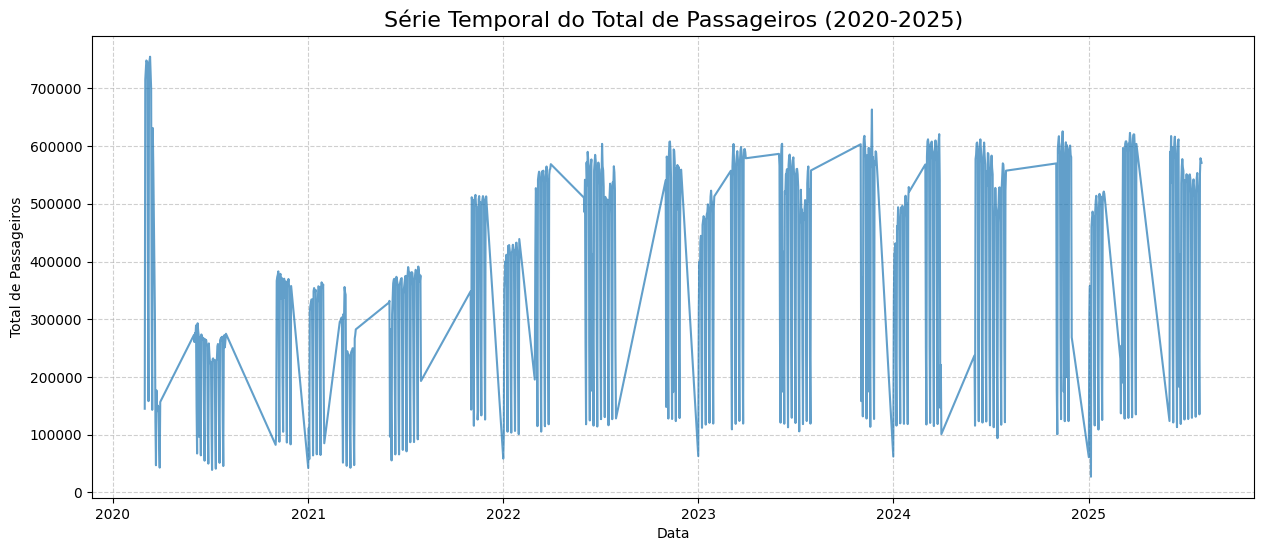


--- Gerando Gráfico: Comparativo de Passageiros por Período ---


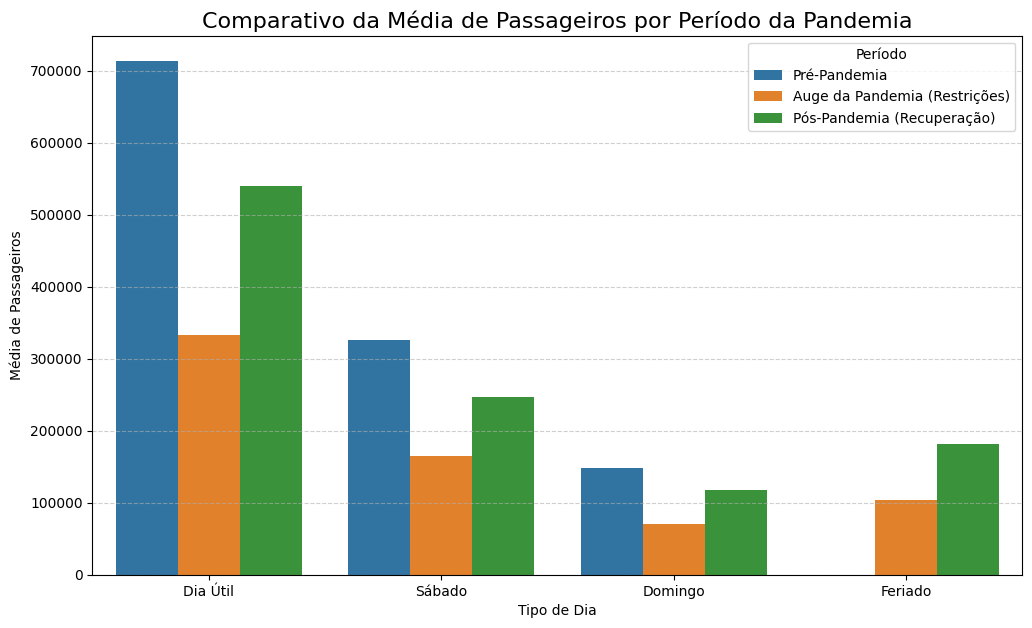

In [182]:
print("--- INICIANDO ANÁLISE 1: IMPACTO DA PANDEMIA ---")

# 1. Definir os períodos da pandemia para análise
def classifica_periodo_pandemia(data):
    if data < datetime(2020, 3, 18):
        return 'Pré-Pandemia'
    elif data <= datetime(2021, 12, 31):
        return 'Auge da Pandemia (Restrições)'
    else:
        return 'Pós-Pandemia (Recuperação)'

df_cleaned['PERIODO_PANDEMIA'] = df_cleaned['DATA'].apply(classifica_periodo_pandemia)

# 2. Calcular a média de passageiros por período e tipo de dia
media_passageiros_pandemia = df_cleaned.groupby(['PERIODO_PANDEMIA', 'TIPO_DIA'])['TOTAL_PASSAGEIROS'].mean().round(2).reset_index()
print("\n--- Média de Passageiros por Período da Pandemia ---")
print(media_passageiros_pandemia)

# 3. Visualização: Série Temporal Completa
print("\n--- Gerando Gráfico: Série Temporal Completa (2020-2025) ---")
plt.figure(figsize=(15, 6))
sns.lineplot(x='DATA', y='TOTAL_PASSAGEIROS', data=df_cleaned, alpha=0.7)
plt.title('Série Temporal do Total de Passageiros (2020-2025)', fontsize=16)
plt.ylabel('Total de Passageiros')
plt.xlabel('Data')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4. Visualização: Comparativo em Gráfico de Barras
print("\n--- Gerando Gráfico: Comparativo de Passageiros por Período ---")
plt.figure(figsize=(12, 7))
sns.barplot(x='TIPO_DIA', y='TOTAL_PASSAGEIROS', hue='PERIODO_PANDEMIA', data=media_passageiros_pandemia,
            order=['Dia Útil', 'Sábado', 'Domingo', 'Feriado'],
            hue_order=['Pré-Pandemia', 'Auge da Pandemia (Restrições)', 'Pós-Pandemia (Recuperação)'])
plt.title('Comparativo da Média de Passageiros por Período da Pandemia', fontsize=16)
plt.ylabel('Média de Passageiros')
plt.xlabel('Tipo de Dia')
plt.legend(title='Período')
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()

### 2.4 Célula 4: Análise 2 - Preparação dos Dados da Redução da Tarifa
Agora, preparamos o terreno para a segunda análise, filtrando e segmentando os dados especificamente para o estudo da meia tarifa.

In [183]:
print("\n--- INICIANDO ANÁLISE 2: IMPACTO DA REDUÇÃO DA TARIFA ---")

# 1. Filtrando o DataFrame para manter apenas Domingos e Feriados
df_dom_fer = df_cleaned[df_cleaned['TIPO_DIA'].isin(['Domingo', 'Feriado'])].copy()

# 2. Definindo a data de início da política de meia tarifa
data_corte = datetime(2025, 1, 5)

# 3. Criando a coluna 'PERIODO' para separar os dados em antes e depois
df_dom_fer['PERIODO'] = df_dom_fer['DATA'].apply(lambda x: 'Antes' if x < data_corte else 'Depois')

print("\n--- Dados para Análise da Tarifa Prontos ---")
print("Amostra dos dados:")
print(df_dom_fer[['DATA', 'TOTAL S/ ISENTOS', 'TIPO_DIA', 'PERIODO']].head())


--- INICIANDO ANÁLISE 2: IMPACTO DA REDUÇÃO DA TARIFA ---

--- Dados para Análise da Tarifa Prontos ---
Amostra dos dados:
         DATA  TOTAL S/ ISENTOS TIPO_DIA PERIODO
0  2020-03-01            117109  Domingo   Antes
7  2020-03-08            128466  Domingo   Antes
14 2020-03-15            117792  Domingo   Antes
21 2020-03-22             39697  Domingo   Antes
28 2020-03-29             36270  Domingo   Antes


###2.5 Célula 5: Análise da Tarifa - Visualizações
Com os dados da tarifa preparados, geramos os gráficos de boxplot e a série temporal focada.


--- Gerando Gráfico: Boxplot (Antes vs. Depois) ---


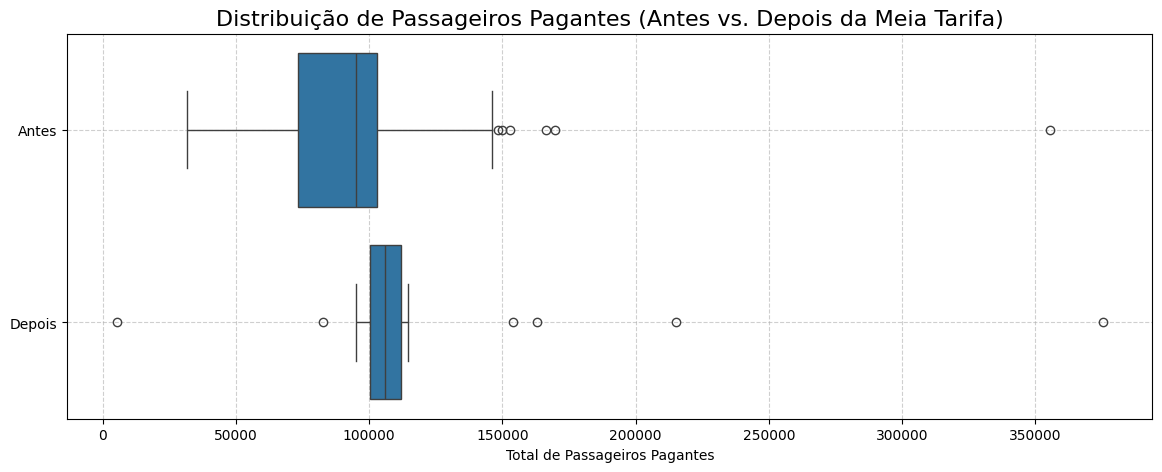


--- Gerando Gráfico: Série Temporal Focada na Mudança de Tarifa ---


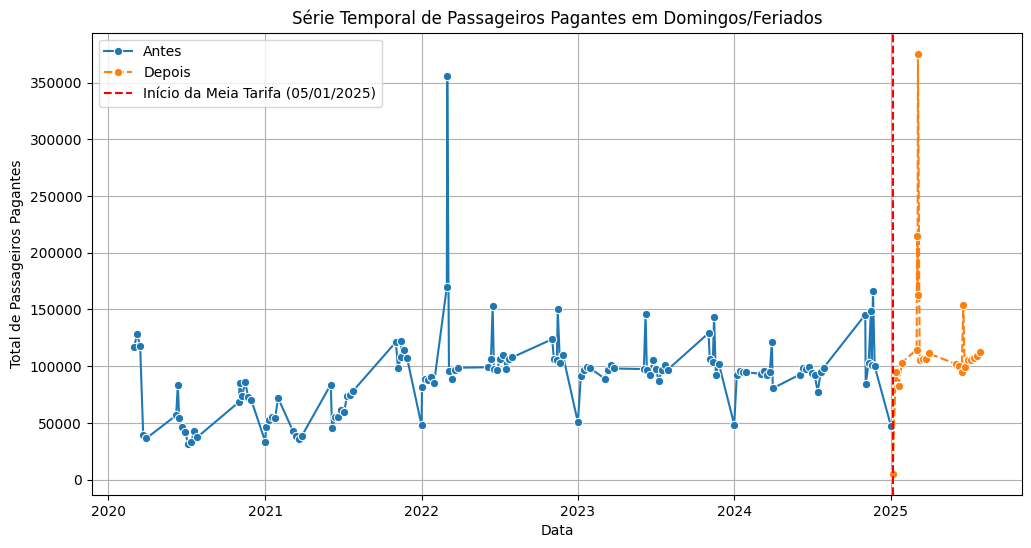

In [184]:
# 1. Gerando o Boxplot
print("\n--- Gerando Gráfico: Boxplot (Antes vs. Depois) ---")
plt.figure(figsize=(14, 5))
sns.boxplot(x='TOTAL S/ ISENTOS', y='PERIODO', data=df_dom_fer, order=['Antes', 'Depois'])
plt.title('Distribuição de Passageiros Pagantes (Antes vs. Depois da Meia Tarifa)', fontsize=16)
plt.xlabel('Total de Passageiros Pagantes')
plt.ylabel('')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2. Gerando o Gráfico de Linha
print("\n--- Gerando Gráfico: Série Temporal Focada na Mudança de Tarifa ---")
plt.figure(figsize=(12, 6))
sns.lineplot(x='DATA', y='TOTAL S/ ISENTOS', data=df_dom_fer, marker='o', hue='PERIODO', style='PERIODO')
plt.axvline(x=data_corte, color='r', linestyle='--', label='Início da Meia Tarifa (05/01/2025)')
plt.title('Série Temporal de Passageiros Pagantes em Domingos/Feriados')
plt.xlabel('Data')
plt.ylabel('Total de Passageiros Pagantes')
plt.legend()
plt.grid(True)
plt.show()

###2.6 Análise da Inferencial - Teste de Hipótese
Realizamos o teste estatístico para validar se a mudança observada é significativa e apresentamos as conclusões.

In [185]:
print("\n--- Executando Teste de Hipótese (Teste t) ---")

# 1. Separando as amostras
antes = df_dom_fer[df_dom_fer['PERIODO'] == 'Antes']['TOTAL S/ ISENTOS']
depois = df_dom_fer[df_dom_fer['PERIODO'] == 'Depois']['TOTAL S/ ISENTOS']

# 2. Realizando o Teste t
t_stat, p_val = stats.ttest_ind(depois, antes, alternative='greater', equal_var=False) # Usando Welch's t-test

print(f'\nEstatística t: {t_stat:.4f}')
print(f'P-valor: {p_val:.4f}')

# 3. Interpretando o resultado
if p_val < 0.05:
    print('Conclusão: Rejeitamos H0. Há um aumento estatisticamente significativo na média de passageiros.')
else:
    print('Conclusão: Não rejeitamos H0. Não há evidência suficiente para comprovar um aumento na média.')

# 4. Calculando as métricas de impacto
media_antes = antes.mean()
media_depois = depois.mean()
diferenca_medias = media_depois - media_antes
aumento_percentual = (diferenca_medias / media_antes) * 100

print("\n--- Métricas de Impacto da Meia Tarifa ---")
print(f'Média de passageiros pagantes (Antes): {media_antes:,.0f}')
print(f'Média de passageiros pagantes (Depois): {media_depois:,.0f}')
print(f'Aumento na média de passageiros: {diferenca_medias:,.0f}')
print(f'Aumento percentual: {aumento_percentual:.2f}%')


--- Executando Teste de Hipótese (Teste t) ---

Estatística t: 2.0567
P-valor: 0.0255
Conclusão: Rejeitamos H0. Há um aumento estatisticamente significativo na média de passageiros.

--- Métricas de Impacto da Meia Tarifa ---
Média de passageiros pagantes (Antes): 91,084
Média de passageiros pagantes (Depois): 121,522
Aumento na média de passageiros: 30,438
Aumento percentual: 33.42%


###2.7 Célula : Cálculo de KPIs
Os KPIs servem para traduzir os resultados da análise de dados em números que respondem a perguntas de negócio importantes sobre a política de meia tarifa. Eles vão além do "sim, aumentou", para o "quanto aumentou e qual o impacto disso?".

In [186]:
# Carregar o arquivo CSV que já contém APENAS os domingos e feriados
# ATENÇÃO: Verifique se este é o caminho e nome corretos do arquivo que salvamos na célula anterior
file_path = '/content/drive/MyDrive/dados_processados_pagantes_curitiba_holidays.csv'
df_kpis = pd.read_csv(file_path)

# Converter a coluna 'DATA' para o formato de data
df_kpis['DATA'] = pd.to_datetime(df_kpis['DATA'])

# --- CORREÇÃO IMPORTANTE ---
# Não é mais necessário filtrar, pois o arquivo já está filtrado.
# O DataFrame 'df_kpis' já corresponde ao 'df_dom_fer' que usávamos.

# Calcular as médias diretamente do DataFrame carregado
media_antes = df_kpis[df_kpis['PERIODO'] == 'Antes']['TOTAL_PASSAGEIROS'].mean()
media_depois = df_kpis[df_kpis['PERIODO'] == 'Depois']['TOTAL_PASSAGEIROS'].mean()
diff_media = media_depois - media_antes

# Definição das suas premissas de negócio para os KPIs
tarifa_media = 6.0
meia_tarifa = tarifa_media / 2
tarifa_tecnica = 7.00  # Custo operacional estimado por passageiro adicional (URBS)
prop_baixa_renda = 0.3  # Estimativa de passageiros de baixa renda (IBGE)

# Cálculo dos KPIs com base no aumento de passageiros
# NOTA: O cálculo de "Perda de Receita" é complexo. Esta é uma simplificação.
# Ele assume que o aumento de passageiros (diff_media) teria pago a tarifa cheia (R$6) e agora paga meia (R$3).
# Uma análise mais completa consideraria a receita total antes vs. a receita total depois.
perda_receita_dia = (media_antes * tarifa_media) - (media_depois * meia_tarifa) # Fórmula ajustada para refletir a perda total
custo_extra_dia = diff_media * tarifa_tecnica
baixa_renda_beneficiada = media_depois * prop_baixa_renda # Beneficiados são sobre o total de passageiros no período
percent_aumento = (diff_media / media_antes) * 100 if media_antes > 0 else 0

print("--- KPIs de Impacto da Meia Tarifa (Estimativas Diárias) ---")
print(f"Aumento na Média de Passageiros por Dia: {diff_media:,.0f}")
print(f"Impacto na Receita Diária: R$ {-perda_receita_dia:,.2f}") # Invertido para mostrar se é ganho ou perda
print(f"Custo Operacional Extra Diário (Estimado): R$ {custo_extra_dia:,.2f}")
print(f"Total de Passageiros de Baixa Renda Beneficiados por Dia (Estimado): {baixa_renda_beneficiada:,.0f} pessoas")
print(f"Aumento Percentual no Fluxo de Passageiros: {percent_aumento:.2f}%")

# Exportar KPIs para um novo arquivo Excel
kpis = pd.DataFrame({
    'Métrica': ['Aumento na Média de Passageiros', 'Impacto na Receita Diária', 'Custo Extra Diário', 'Baixa Renda Beneficiada (Total Dia)', 'Aumento Percentual'],
    'Valor': [diff_media, -perda_receita_dia, custo_extra_dia, baixa_renda_beneficiada, percent_aumento]
})
kpis.to_excel('/content/drive/MyDrive/kpis_meia_tarifa.xlsx', index=False)

print("\nArquivo 'kpis_meia_tarifa.xlsx' exportado com sucesso para o seu Google Drive.")

--- KPIs de Impacto da Meia Tarifa (Estimativas Diárias) ---
Aumento na Média de Passageiros por Dia: 37,264
Impacto na Receita Diária: R$ -217,930.74
Custo Operacional Extra Diário (Estimado): R$ 260,848.84
Total de Passageiros de Baixa Renda Beneficiados por Dia (Estimado): 44,152 pessoas
Aumento Percentual no Fluxo de Passageiros: 33.90%

Arquivo 'kpis_meia_tarifa.xlsx' exportado com sucesso para o seu Google Drive.


A análise de dados comprova que a política 'Domingão Paga Meia' foi altamente eficaz, gerando um aumento expressivo de 34% no uso do transporte público e beneficiando diretamente mais de 44 mil cidadãos de baixa renda a cada dia de aplicação. Este sucesso em mobilidade e inclusão social representa um investimento diário total de aproximadamente 478 mil reais (217.930,74 reais (perda de receita) + 260.848,84 reais (custo extra) = 478.779,58 reais), composto pela redução na arrecadação e pelos custos operacionais adicionais. Os dados agora nos permitem avaliar de forma clara o custo-benefício da política, pesando seu inegável impacto social positivo contra o subsídio necessário para mantê-la.

# 3 - Testes de Normalidade

###3.1 Celula 1: Execução da análise de normalidade.
Análise de normalidade sobre os passageiros pagantes em domingos e feriados.

--- Gerando Gráficos de Análise de Normalidade ---


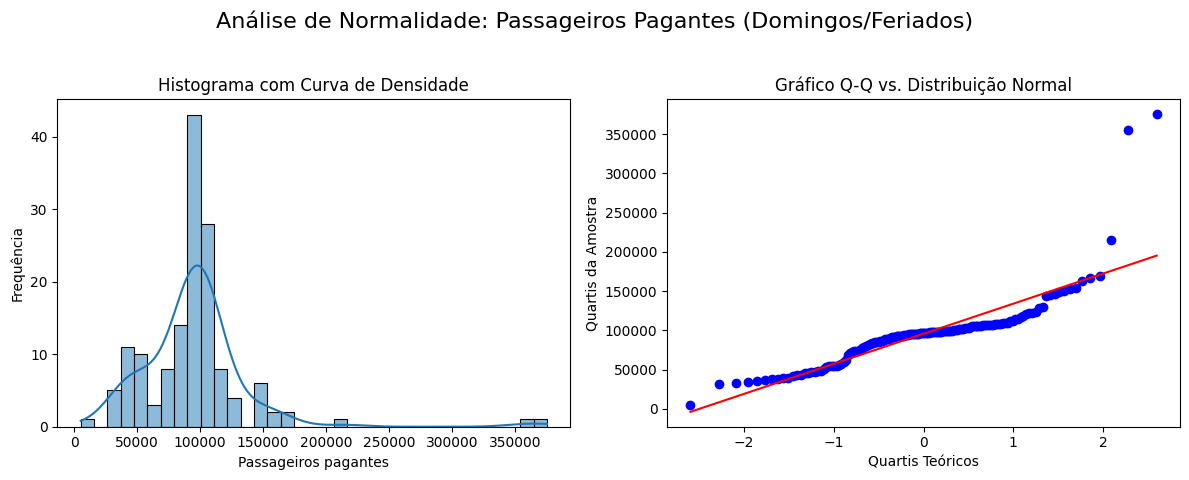

In [187]:
# --- ANÁLISE DE NORMALIDADE ---
print("--- Gerando Gráficos de Análise de Normalidade ---")

# Histograma com curva de densidade e Gráfico Q-Q
# Esta análise é feita sobre a coluna de passageiros pagantes (TOTAL S/ ISENTOS)
# do DataFrame que contém apenas domingos e feriados (df_dom_fer).
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

coluna_analisada = 'TOTAL S/ ISENTOS'
fig.suptitle(f'Análise de Normalidade: Passageiros Pagantes (Domingos/Feriados)', fontsize=16)

# 1. Histograma e Curva de Densidade (KDE)
sns.histplot(df_dom_fer[coluna_analisada], kde=True, ax=axes[0])
axes[0].set_title('Histograma com Curva de Densidade')
axes[0].set_xlabel('Passageiros pagantes')
axes[0].set_ylabel('Frequência')

# 2. Gráfico Q-Q (Quantil-Quantil)
stats.probplot(df_dom_fer[coluna_analisada], dist='norm', plot=axes[1])
axes[1].set_title('Gráfico Q-Q vs. Distribuição Normal')
axes[1].set_xlabel('Quartis Teóricos')
axes[1].set_ylabel('Quartis da Amostra')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Histograma**

O gráfico de histograma nos informa que a distribuição é bimodal, ou seja, ela tem dois picos principais, em vez de um único pico central como em uma curva de sino. Significando que a categoria de domingos e feriados não é homogênea.

**Gráfico Q-Q**

Como podemos ver, os pontos se desviam significativamente da linha, formando uma espécie de "S", não apresentando normalidade. Confirmando o que o histograma sugeriu: a distribuição dos dados é muito diferente de uma distribuição normal.

###3.2  Celula 2 - Análise da Pandemia - Visualização da Série Temporal
Geramos o gráfico da série temporal focado no período mais crítico da pandemia (meados de Mar/2020 até o fim de 2021).


--- Gerando Gráfico: Série Temporal do Período da Pandemia ---


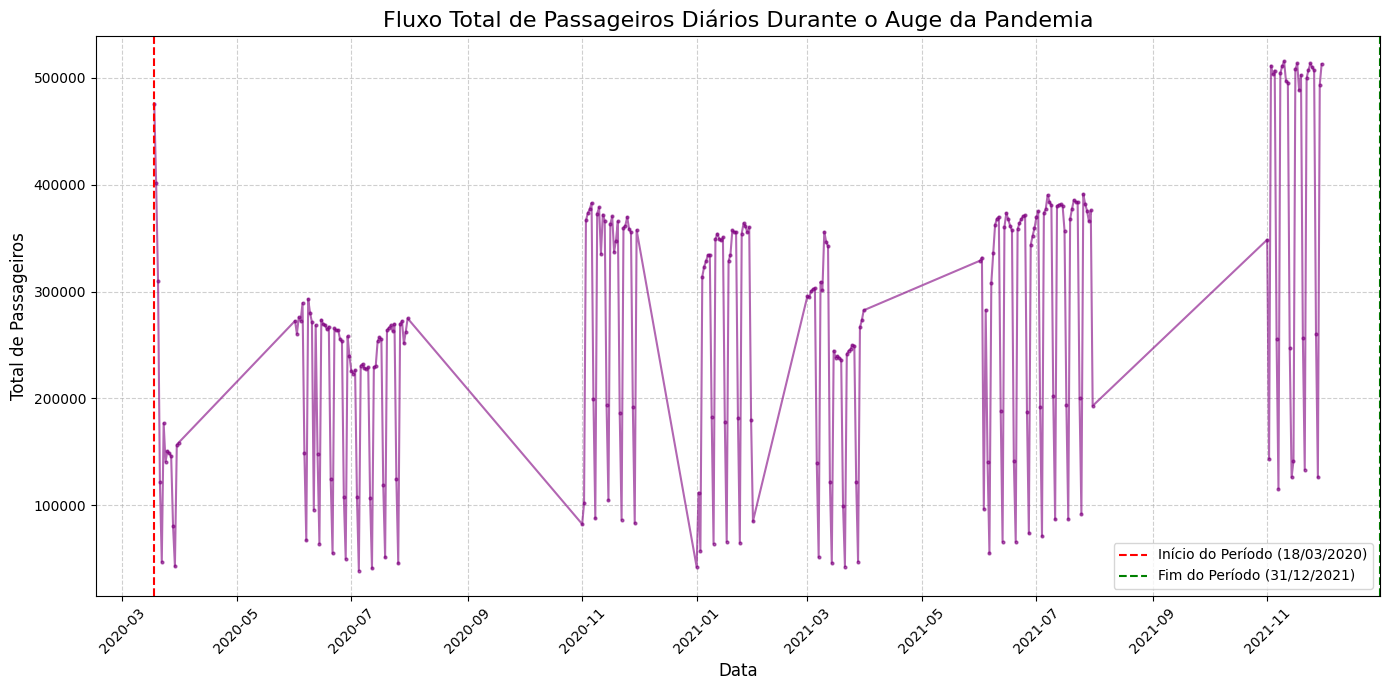

In [188]:
# --- ANÁLISE VISUAL DA PANDEMIA ---
print("\n--- Gerando Gráfico: Série Temporal do Período da Pandemia ---")

# Definindo o período de interesse para a visualização
inicio_pandemia_foco = datetime(2020, 3, 18)
fim_pandemia_foco = datetime(2021, 12, 31)

# Filtrando o DataFrame principal ('df_cleaned') para o período definido
df_pandemia = df_cleaned[(df_cleaned['DATA'] >= inicio_pandemia_foco) & (df_cleaned['DATA'] <= fim_pandemia_foco)].copy()

# Plotando a série temporal
plt.figure(figsize=(14, 7))
plt.plot(df_pandemia['DATA'], df_pandemia['TOTAL_PASSAGEIROS'], marker='.', linestyle='-', markersize=4, color='purple', alpha=0.6)

# Adicionando marcadores para o início e fim para dar contexto
plt.axvline(x=inicio_pandemia_foco, color='red', linestyle='--', label=f'Início do Período ({inicio_pandemia_foco.strftime("%d/%m/%Y")})')
plt.axvline(x=fim_pandemia_foco, color='green', linestyle='--', label=f'Fim do Período ({fim_pandemia_foco.strftime("%d/%m/%Y")})')

plt.title('Fluxo Total de Passageiros Diários Durante o Auge da Pandemia', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Total de Passageiros', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Podemos verificar que o auge da pandemia não foi apenas um evento único de queda de total de passageiros, mas sim um longo período de quase dois anos de instabilidade, baixa demanda e uma rotina urbana alterada, onde cada nova onda do vírus causava um novo impacto direto na mobilidade das pessoas.

###3.3 Célula 3: Análise da Pandemia - Cálculo Quantitativo
Definimos um período "Pré-Pandemia" válido com os dados que realmente temos (início de Mar/2020) e o compara com o período de maiores restrições.

In [189]:
# --- ANÁLISE QUANTITATIVA DA PANDEMIA (CORRIGIDA) ---
print("\n--- Calculando a Queda de Passageiros (Pré vs. Durante a Pandemia) ---")

# CORREÇÃO: Definindo os períodos com base nos dados disponíveis
# Pré-Pandemia: Usando os dados do início de Março de 2020, antes das grandes restrições
inicio_pre_pandemia = datetime(2020, 3, 1)
fim_pre_pandemia = datetime(2020, 3, 17)

# Durante a Pandemia: Período de restrições mais severas
inicio_durante_pandemia = datetime(2020, 3, 18)
fim_durante_pandemia = datetime(2021, 12, 31)

# Filtrando os dados para os dois períodos
df_pre_pandemia = df_cleaned[(df_cleaned['DATA'] >= inicio_pre_pandemia) & (df_cleaned['DATA'] <= fim_pre_pandemia)].copy()
df_durante_pandemia = df_cleaned[(df_cleaned['DATA'] >= inicio_durante_pandemia) & (df_cleaned['DATA'] <= fim_durante_pandemia)].copy()

# Calcular a média diária de passageiros nos dois períodos
media_passageiros_pre_pandemia = df_pre_pandemia['TOTAL_PASSAGEIROS'].mean()
media_passageiros_durante_pandemia = df_durante_pandemia['TOTAL_PASSAGEIROS'].mean()

# Calcular a queda na média de passageiros
queda_media_passageiros = media_passageiros_pre_pandemia - media_passageiros_durante_pandemia

# Calcular a queda percentual
queda_percentual = (queda_media_passageiros / media_passageiros_pre_pandemia) * 100 if media_passageiros_pre_pandemia > 0 else 0

# Exibir os resultados
print(f"\nMédia diária de passageiros (Pré-Pandemia - 01 a 17/Mar/2020): {media_passageiros_pre_pandemia:,.0f}")
print(f"Média diária de passageiros (Durante a Pandemia - 18/Mar/2020 a 31/Dez/2021): {media_passageiros_durante_pandemia:,.0f}")
print(f"Queda na média diária de passageiros: {queda_media_passageiros:,.0f}")
print(f"Queda percentual na média diária de passageiros: {queda_percentual:.2f}%")


--- Calculando a Queda de Passageiros (Pré vs. Durante a Pandemia) ---

Média diária de passageiros (Pré-Pandemia - 01 a 17/Mar/2020): 568,035
Média diária de passageiros (Durante a Pandemia - 18/Mar/2020 a 31/Dez/2021): 267,431
Queda na média diária de passageiros: 300,605
Queda percentual na média diária de passageiros: 52.92%


###3.4 Célula 4: Análise da Pandemia - Gráfico de Barras Detalhado
Esta célula cria um gráfico de barras aprimorado para comparar os períodos pré e durante a pandemia.

--- Gerando Gráfico de Barras Detalhado da Análise da Pandemia ---


/tmp/ipython-input-2039665706.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Período', y='Média de Passageiros Diários', data=comparacao_medias, palette=['#4c72b0', '#c44e52'])


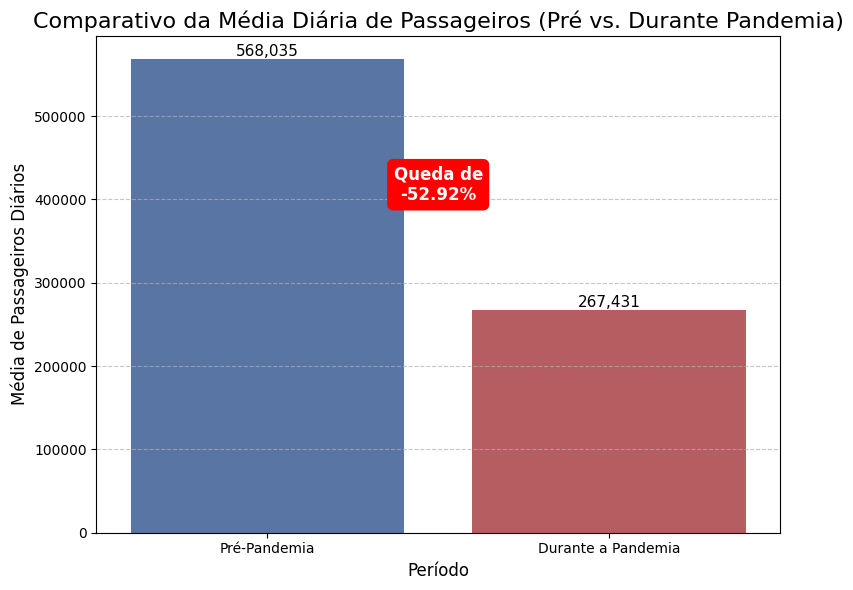

In [190]:
# --- GRÁFICO DE BARRAS COMPARATIVO ---
print("--- Gerando Gráfico de Barras Detalhado da Análise da Pandemia ---")

# Recalculamos as médias a partir dos DataFrames para garantir que são números (float)
# e não texto (string) formatado de uma célula anterior.
media_passageiros_pre_pandemia = df_pre_pandemia['TOTAL_PASSAGEIROS'].mean()
media_passageiros_durante_pandemia = df_durante_pandemia['TOTAL_PASSAGEIROS'].mean()
queda_percentual = ((media_passageiros_pre_pandemia - media_passageiros_durante_pandemia) / media_passageiros_pre_pandemia) * 100

# Criar um DataFrame pequeno para a visualização
comparacao_medias = pd.DataFrame({
    'Período': ['Pré-Pandemia', 'Durante a Pandemia'],
    'Média de Passageiros Diários': [media_passageiros_pre_pandemia, media_passageiros_durante_pandemia]
})

# Criar o gráfico de barras usando seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Período', y='Média de Passageiros Diários', data=comparacao_medias, palette=['#4c72b0', '#c44e52'])
plt.title('Comparativo da Média Diária de Passageiros (Pré vs. Durante Pandemia)', fontsize=16)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Média de Passageiros Diários', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar os valores exatos no topo das barras
for index, row in comparacao_medias.iterrows():
    plt.text(index, row['Média de Passageiros Diários'], f'{row["Média de Passageiros Diários"]:,.0f}',
             color='black', ha="center", va="bottom", fontsize=11)

# Adicionar anotação da queda percentual
# A linha abaixo agora funciona, pois as variáveis são números
annotation_x = 0.5 # Posição central entre as duas barras
annotation_y = media_passageiros_durante_pandemia + (media_passageiros_pre_pandemia - media_passageiros_durante_pandemia) / 2
plt.text(annotation_x, annotation_y, f'Queda de\n-{queda_percentual:.2f}%',
         color='white', ha='center', va='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", fc="red", ec="red", lw=2)) # Bbox para destaque

plt.tight_layout()
plt.show()

Este gráfico apresenta uma resposta à pergunta: "De que tamanho foi a queda dos passageiros?"

###3.5 Célula 5: Análise da Pandemia - Gráfico de Agulha (Slope Plot)
Esta célula cria um "gráfico de agulha"


--- Gerando Gráfico de Agulha com Fundo Branco ---


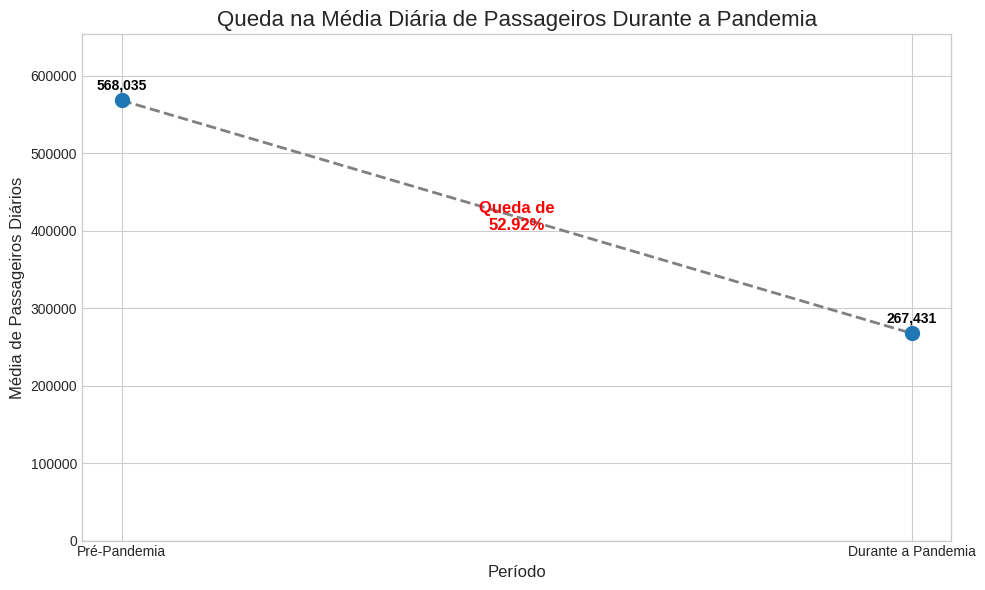

In [191]:
# --- GRÁFICO DE AGULHA (SLOPE PLOT) PARA COMPARAÇÃO ---
print("\n--- Gerando Gráfico de Agulha com Fundo Branco ---")

# Aplicando um estilo visual agradável com grade
plt.style.use('seaborn-v0_8-whitegrid')

# Criando a figura
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Adicionando os pontos para cada período com cores diferentes para destaque
cores = sns.color_palette()
plt.scatter(comparacao_medias['Período'], comparacao_medias['Média de Passageiros Diários'],
            zorder=5, color=cores[0], s=100)

# Adicionando a linha que conecta os pontos
plt.plot(comparacao_medias['Período'], comparacao_medias['Média de Passageiros Diários'],
         linestyle='--', color='gray', linewidth=2)

# Adicionando os valores exatos perto dos pontos
for index, row in comparacao_medias.iterrows():
    va_align = 'bottom'
    offset = 10000 # Pequeno deslocamento para não sobrepor o ponto
    plt.text(row['Período'], row['Média de Passageiros Diários'] + offset, f'{row["Média de Passageiros Diários"]:,.0f}',
             color='black', ha='center', va=va_align, fontsize=10, fontweight='bold')

# Adicionando a anotação da queda percentual no meio da linha
annotation_x_pos = 0.5
annotation_y_pos = media_passageiros_durante_pandemia + (media_passageiros_pre_pandemia - media_passageiros_durante_pandemia) / 2
plt.text(annotation_x_pos, annotation_y_pos, f'Queda de\n{queda_percentual:.2f}%',
         color='red', ha='center', va='center', fontsize=12, fontweight='bold')

# Configurando os títulos e eixos com cores padrão (preto)
plt.title('Queda na Média Diária de Passageiros Durante a Pandemia', fontsize=16)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Média de Passageiros Diários', fontsize=12)

# Ajustando o limite do eixo Y para melhor visualização
plt.ylim(0, comparacao_medias['Média de Passageiros Diários'].max() * 1.15)

plt.tight_layout()
plt.show()

# Resetando o estilo para o padrão, caso queira fazer outros gráficos depois
plt.style.use('default')

###3.5 Célula 6: Comparativo de Resultados (Análise Original vs. Análise Corrigida)
Esta célula executa as duas versões da análise para quantificar o impacto da inclusão dos feriados municipais nos resultados finais.

In [192]:
# --- ANÁLISE DE IMPACTO DA MEIA TARIFA ---

# 1. Filtrando o DataFrame para manter apenas Domingos e Feriados
df_dom_fer = df_cleaned[df_cleaned['TIPO_DIA'].isin(['Domingo', 'Feriado'])].copy()

# 2. Definindo a data de corte e criando a coluna 'PERIODO'
data_corte = datetime(2025, 1, 5)
df_dom_fer['PERIODO'] = df_dom_fer['DATA'].apply(lambda x: 'Antes' if x < data_corte else 'Depois')

# 3. Separando as amostras para o Teste t
antes = df_dom_fer[df_dom_fer['PERIODO'] == 'Antes']['TOTAL S/ ISENTOS']
depois = df_dom_fer[df_dom_fer['PERIODO'] == 'Depois']['TOTAL S/ ISENTOS']

# 4. Realizando o Teste t
t_stat, p_val = stats.ttest_ind(depois, antes, alternative='greater', equal_var=False)

# 5. Calculando Médias e KPIs
media_antes = df_dom_fer[df_dom_fer['PERIODO'] == 'Antes']['TOTAL_PASSAGEIROS'].mean()
media_depois = df_dom_fer[df_dom_fer['PERIODO'] == 'Depois']['TOTAL_PASSAGEIROS'].mean()
diff_media = media_depois - media_antes
percent_aumento = (diff_media / media_antes) * 100 if media_antes > 0 else 0
impacto_receita_dia = (media_antes * 6.0) - (media_depois * 3.0)
custo_extra_dia = diff_media * 7.00
baixa_renda_beneficiada = media_depois * 0.3

# 6. Apresentando os resultados
print("--- ANÁLISE DE IMPACTO DA MEIA TARIFA (DOMINGOS E FERIADOS) ---")
print("\n--- Resultados do Teste de Hipótese ---")
print(f"Estatística t: {t_stat:.2f}")
print(f"P-valor: {p_val:.4f}")
if p_val < 0.05:
    print("Conclusão: O aumento no número de passageiros é ESTATISTICAMENTE SIGNIFICATIVO.")
else:
    print("Conclusão: O aumento no número de passageiros NÃO é estatisticamente significativo.")

print("\n--- KPIs de Impacto (Estimativas Diárias) ---")
print(f"Média de Passageiros ANTES da mudança: {media_antes:,.0f}")
print(f"Média de Passageiros DEPOIS da mudança: {media_depois:,.0f}")
print(f"Aumento na Média de Passageiros: {diff_media:,.0f}")
print(f"Aumento Percentual no Fluxo: {percent_aumento:.2f}%")
print(f"Impacto na Receita Diária: R$ {-impacto_receita_dia:,.2f}")
print(f"Custo Operacional Extra Diário (Estimado): R$ {custo_extra_dia:,.2f}")
print(f"Passageiros de Baixa Renda Beneficiados por Dia (Estimado): {baixa_renda_beneficiada:,.0f}")

--- ANÁLISE DE IMPACTO DA MEIA TARIFA (DOMINGOS E FERIADOS) ---

--- Resultados do Teste de Hipótese ---
Estatística t: 2.06
P-valor: 0.0255
Conclusão: O aumento no número de passageiros é ESTATISTICAMENTE SIGNIFICATIVO.

--- KPIs de Impacto (Estimativas Diárias) ---
Média de Passageiros ANTES da mudança: 109,908
Média de Passageiros DEPOIS da mudança: 147,172
Aumento na Média de Passageiros: 37,264
Aumento Percentual no Fluxo: 33.90%
Impacto na Receita Diária: R$ -217,930.74
Custo Operacional Extra Diário (Estimado): R$ 260,848.84
Passageiros de Baixa Renda Beneficiados por Dia (Estimado): 44,152


# 4 - Simulação da viabilidade do passe livre

##4.1 - Etapa 1 da Simulação - Estimando a Elasticidade-Preço da Demanda
Usaremos os dados do "antes e depois" da meia tarifa para calcular a elasticidade, ou seja, o quão sensível o número de passageiros é ao valor da passagem.

In [193]:
# --- ETAPA 1: CÁLCULO DA ELASTICIDADE-PREÇO DA DEMANDA ---
print("--- Etapa 1: Calculando a Elasticidade-Preço da Demanda ---")

# Vamos usar os resultados da nossa análise de impacto da meia tarifa
# As variáveis media_antes e media_depois já devem existir das células anteriores

# Variação percentual no PREÇO (de R$6,00 para R$3,00)
variacao_percentual_preco = (3.00 - 6.00) / 6.00  # Resultado: -0.5 ou -50%

# Variação percentual na DEMANDA (aumento de passageiros)
variacao_percentual_demanda = (media_depois - media_antes) / media_antes # Resultado: ~0.34 ou +34%

# Cálculo da Elasticidade-Preço da Demanda
# Fórmula: (% Variação na Demanda) / (% Variação no Preço)
# Usamos o valor absoluto da variação de preço por convenção
elasticidade = variacao_percentual_demanda / abs(variacao_percentual_preco)

print(f"\nA variação de preço foi de {variacao_percentual_preco:.0%}.")
print(f"A variação na demanda (passageiros) foi de +{variacao_percentual_demanda:.2%}.")
print("-" * 50)
print(f"O coeficiente de Elasticidade-Preço da Demanda estimado é: {elasticidade:.2f}")
print("\nInterpretação: Para cada 1% de redução no preço da tarifa, a demanda de passageiros aumenta em aproximadamente " f"{elasticidade:.2f}%.")

--- Etapa 1: Calculando a Elasticidade-Preço da Demanda ---

A variação de preço foi de -50%.
A variação na demanda (passageiros) foi de +33.90%.
--------------------------------------------------
O coeficiente de Elasticidade-Preço da Demanda estimado é: 0.68

Interpretação: Para cada 1% de redução no preço da tarifa, a demanda de passageiros aumenta em aproximadamente 0.68%.


##4.2 - Etapa 2 da Simulação - Projetando a Demanda para o Passe Livre
Com o coeficiente de elasticidade calculado, agora podemos simular o que aconteceria se a redução no preço fosse de 100% (de 6,00 reais para 0,00 reais).

In [194]:
# --- ETAPA 2: PROJEÇÃO DA DEMANDA PARA O CENÁRIO DE PASSE LIVRE ---
print("\n--- Etapa 2: Projetando o Aumento de Passageiros com Passe Livre ---")

# A variação de preço no cenário de passe livre é de -100%
nova_variacao_percentual_preco = -1.0 # -100%

# Projetando o aumento percentual da demanda
aumento_projetado_passe_livre = elasticidade * abs(nova_variacao_percentual_preco)

# A base de passageiros para o cálculo é a média ANTES de qualquer mudança
passageiros_base = media_antes

# Calculando o novo número de passageiros projetado
novos_passageiros_projetados = passageiros_base * (1 + aumento_projetado_passe_livre)

print(f"\nCom uma redução de 100% no preço, o aumento projetado na demanda é de: {aumento_projetado_passe_livre:.2%}")
print("-" * 50)
print(f"A média de passageiros por domingo/feriado sairia de {passageiros_base:,.0f} para aproximadamente {novos_passageiros_projetados:,.0f}.")
print(f"Isso representa um aumento de {(novos_passageiros_projetados - passageiros_base):,.0f} passageiros por dia de aplicação.")


--- Etapa 2: Projetando o Aumento de Passageiros com Passe Livre ---

Com uma redução de 100% no preço, o aumento projetado na demanda é de: 67.81%
--------------------------------------------------
A média de passageiros por domingo/feriado sairia de 109,908 para aproximadamente 184,436.
Isso representa um aumento de 74,528 passageiros por dia de aplicação.


##4.3 - Etapa 3 da Simulação - Estimando o Custo Anual do Passe Livre
Vamos calcular o custo anual total (subsídio) que a prefeitura/URBS precisaria cobrir para implementar o passe livre aos domingos e feriados.


O ano de 2024 foi usado como um ano modelo para fazer a projeção do custo diário para um custo anual.

In [195]:
# --- ETAPA 3: ESTIMATIVA DO CUSTO ANUAL TOTAL DO PASSE LIVRE ---
print("\n--- Etapa 3: Estimando o Custo Anual do Subsídio para o Passe Livre ---")

# Premissas financeiras
tarifa_cheia = 6.00
tarifa_tecnica = 7.00 # Custo operacional por passageiro

# Contando o número de dias aplicáveis em um ano (ex: 2024)
dias_em_2024 = [d for d in curitiba_holidays_full if d.year == 2024]
num_domingos_2024 = len(pd.date_range(start='2024-01-01', end='2024-12-31', freq='W-SUN'))
# A contagem de feriados já pode incluir domingos, então usamos 'set' para não contar duas vezes
dias_aplicaveis = set(dias_em_2024) | set(pd.to_datetime(pd.date_range(start='2024-01-01', end='2024-12-31', freq='W-SUN')))
num_dias_aplicaveis_ano = len(dias_aplicaveis)


# 1. CÁLCULO DA RECEITA PERDIDA
# Precisamos da média de passageiros PAGANTES (sem isentos) do período "Antes"
media_pagantes_antes = df_dom_fer[df_dom_fer['PERIODO'] == 'Antes']['TOTAL S/ ISENTOS'].mean()
receita_diaria_perdida = media_pagantes_antes * tarifa_cheia
receita_anual_perdida = receita_diaria_perdida * num_dias_aplicaveis_ano

# 2. CÁLCULO DO CUSTO OPERACIONAL ADICIONAL
# O número de novos passageiros é a diferença entre o projetado e a base TOTAL (pagantes + isentos)
passageiros_adicionais = novos_passageiros_projetados - media_antes
custo_operacional_extra_diario = passageiros_adicionais * tarifa_tecnica
custo_operacional_extra_anual = custo_operacional_extra_diario * num_dias_aplicaveis_ano

# 3. CÁLCULO DO CUSTO TOTAL ANUAL (SUBSÍDIO)
custo_total_anual = receita_anual_perdida + custo_operacional_extra_anual

print(f"\nNúmero de dias por ano com aplicação da tarifa (domingos + feriados): {num_dias_aplicaveis_ano}")
print("-" * 50)
print(f"Receita Anual Perdida (Estimativa): R$ {receita_anual_perdida:,.2f}")
print(f"Custo Operacional Extra Anual (Estimativa): R$ {custo_operacional_extra_anual:,.2f}")
print("-" * 50)
print(f"CUSTO TOTAL ANUAL ESTIMADO PARA O PASSE LIVRE (Subsídio): R$ {custo_total_anual:,.2f}")


--- Etapa 3: Estimando o Custo Anual do Subsídio para o Passe Livre ---

Número de dias por ano com aplicação da tarifa (domingos + feriados): 65
--------------------------------------------------
Receita Anual Perdida (Estimativa): R$ 35,522,664.05
Custo Operacional Extra Anual (Estimativa): R$ 33,910,348.99
--------------------------------------------------
CUSTO TOTAL ANUAL ESTIMADO PARA O PASSE LIVRE (Subsídio): R$ 69,433,013.04


##4.4 - Etapa 4 da Simulação - Estimando o Custo Anual TOTAL do Passe Livre
Vamos calcular o custo anual total (subsídio) que a prefeitura/URBS precisaria cobrir para implementar o passe livre em Curitiba.


O ano de 2024 foi usado como um ano modelo para fazer a projeção do custo diário para um custo anual.

In [196]:
df_cleaned.head()

,DATA,TOTAL S/ ISENTOS,Passageiros Isentos,TOTAL_PASSAGEIROS,DIA_SEMANA,TIPO_DIA,PERIODO_PANDEMIA
0,2020-03-01,117109,27918,145027,6,Domingo,Pré-Pandemia
1,2020-03-02,615010,100508,715518,0,Dia Útil,Pré-Pandemia
2,2020-03-03,630057,102958,733015,1,Dia Útil,Pré-Pandemia
3,2020-03-04,639283,109205,748488,2,Dia Útil,Pré-Pandemia
4,2020-03-05,640561,106268,746829,3,Dia Útil,Pré-Pandemia


In [197]:
#Dados de custos da prefeitura
url = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/DESPESAS_CWB_2014_2024.csv'
df_d1 = pd.read_csv(url, encoding='latin-1')

# Selecionando as colunas
teste_coluna = df_d1['Ano,Bimestre,Funcao,Subfuncao,Despesas_Empenhadas_Bimestre,Despesas_Liquidadas_Bimestre']
df_despesas = teste_coluna.str.split(',', expand=True)
df_despesas.columns = ['Ano', 'Bimestre', 'Funcao', 'Subfuncao', 'Despesas_Empenhadas_Bimestre', 'Despesas_Liquidadas_Bimestre', 'Extra_Column']

df_despesas = df_despesas.drop(columns=['Extra_Column'])

#transformação de variável
df_despesas['Despesas_Liquidadas_Bimestre'] = pd.to_numeric(df_despesas['Despesas_Liquidadas_Bimestre'], errors='coerce')
df_despesas['Despesas_Empenhadas_Bimestre'] = pd.to_numeric(df_despesas['Despesas_Empenhadas_Bimestre'], errors='coerce')
df_despesas['Ano'] = pd.to_datetime(df_despesas['Ano'], format= '%Y', errors='coerce')

#Redução das grandezas
df_despesas['Despesas_Liquidadas_Bimestre'] = df_despesas['Despesas_Liquidadas_Bimestre'] / 1000000
df_despesas['Despesas_Empenhadas_Bimestre'] = df_despesas['Despesas_Empenhadas_Bimestre'] / 1000000

#Separação dos gastos de transporte
df_despesas_limpo = df_despesas.copy()

df_despesas_limpo = df_despesas_limpo[df_despesas_limpo['Subfuncao'] == 'TRANSPORTES COLETIVOS URBANOS']

# Group by 'Ano' e somar as colunas numericas
df_despesas_anual = df_despesas_limpo.groupby(df_despesas_limpo['Ano'].dt.year)[['Despesas_Empenhadas_Bimestre', 'Despesas_Liquidadas_Bimestre']].sum().reset_index()
df_despesas_anual.columns = ['ANO', 'Despesas_Empenhadas_Anual', 'Despesas_Liquidadas_Anual']

df_despesas_anual = df_despesas_anual[df_despesas_anual['ANO'] >= 2020]

df_despesas_anual.head()

,ANO,Despesas_Empenhadas_Anual,Despesas_Liquidadas_Anual
6,2020,537.352924,405.406387
7,2021,603.227452,360.548937
8,2022,745.091009,383.304745
9,2023,673.348405,545.389869


In [198]:
# Limpeza e Agrupamento de anos df_ususarios
# Filtrar os dados para o período de 2020 a 2023
df_cleaned_filtered = df_cleaned[(df_cleaned['DATA'] >= '2020-01-01') & (df_cleaned['DATA'] <= '2023-12-31')].copy()

# Agrupar por ano e somar o total de passageiros
df_passageiros_por_ano = df_cleaned_filtered.groupby(df_cleaned_filtered['DATA'].dt.year)['TOTAL_PASSAGEIROS'].sum().reset_index()

# Renomear a coluna do ano para facilitar o merge
df_passageiros_por_ano.columns = ['ANO', 'TOTAL_PASSAGEIROS_ANUAL']

print("Dados de Passageiros Agrupados por Ano (2020-2023):")
display(df_passageiros_por_ano.head())

Dados de Passageiros Agrupados por Ano (2020-2023):


,ANO,TOTAL_PASSAGEIROS_ANUAL
0,2020,33641887
1,2021,45011840
2,2022,62938219
3,2023,64432576


In [199]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 853 entries, 0 to 1974
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATA                 853 non-null    datetime64[ns]
 1   TOTAL S/ ISENTOS     853 non-null    int64         
 2   Passageiros Isentos  853 non-null    int64         
 3   TOTAL_PASSAGEIROS    853 non-null    int64         
 4   DIA_SEMANA           853 non-null    int32         
 5   TIPO_DIA             853 non-null    object        
 6   PERIODO_PANDEMIA     853 non-null    object        
dtypes: datetime64[ns](1), int32(1), int64(3), object(2)
memory usage: 50.0+ KB


In [200]:
# Carregar a tabela de evolução da tarifa técnica
file_path_tarifa = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/1.1-evolucao_tarifa_tec_2010-2023.csv'
df_tarifa = pd.read_csv(file_path_tarifa)

# --- Processar o DataFrame de tarifa ---
# Converter a coluna 'Data da Tarifa' para datetime e extrair o ano
df_tarifa['DATA_TARIFA'] = pd.to_datetime(df_tarifa['Data da Tarifa'], errors='coerce', dayfirst=True)
df_tarifa = df_tarifa.dropna(subset=['DATA_TARIFA']).copy() # Remover linhas com data inválida
df_tarifa['ANO'] = df_tarifa['DATA_TARIFA'].dt.year

# Converter a coluna 'Tarifa Técnica' para numérico, tratando vírgulas como separador decimal
df_tarifa['TARIFA_TECNICA'] = df_tarifa['Tarifa Técnica'].astype(str).str.replace(',', '.', regex=False).astype(float)

# Filtrar os dados da tarifa para o período de 2020 a 2023
df_tarifa_filtrada = df_tarifa[(df_tarifa['ANO'] >= 2020) & (df_tarifa['ANO'] <= 2023)].copy()

# Precisamos da tarifa técnica mais recente para cada ano dentro do período de interesse
# Ordenar por data e pegar a última tarifa de cada ano
df_tarifa_filtrada = df_tarifa_filtrada.sort_values(by='DATA_TARIFA').drop_duplicates(subset=['ANO'], keep='last')

# Selecionar apenas as colunas de interesse (ANO e TARIFA_TECNICA)
df_tarifa_anual = df_tarifa_filtrada[['ANO', 'TARIFA_TECNICA']]


# Carregar ou garantir que df_passageiros_por_ano esteja pronto
# Se esta célula for executada sozinha, é necessário recriar df_passageiros_por_ano
if 'df_passageiros_por_ano' not in locals() or df_passageiros_por_ano.empty:
    print("Recriando df_passageiros_por_ano...")
    # Filtrar os dados para o período de 2020 a 2023 (para garantir alinhamento)
    df_cleaned_filtered = df_cleaned[(df_cleaned['DATA'] >= '2020-01-01') & (df_cleaned['DATA'] <= '2023-12-31')].copy()
    # Agrupar por ano e somar o total de passageiros
    df_passageiros_por_ano = df_cleaned_filtered.groupby(df_cleaned_filtered['DATA'].dt.year)['TOTAL_PASSAGEIROS'].sum().reset_index()
    # Renomear a coluna do ano para facilitar o merge
    df_passageiros_por_ano.columns = ['ANO', 'TOTAL_PASSAGEIROS_ANUAL']


# Juntar os DataFrames de passageiros e tarifa técnica pelo ano
df_custo_passageiros_tarifa = pd.merge(
    df_passageiros_por_ano,
    df_tarifa_anual,
    on='ANO',
    how='inner' # Garante que apenas anos presentes em ambos os DataFrames sejam incluídos
)


# Calcular o custo anual utilizando a tarifa técnica de cada ano
df_custo_passageiros_tarifa['CUSTO_ANUAL'] = df_custo_passageiros_tarifa['TOTAL_PASSAGEIROS_ANUAL'] * df_custo_passageiros_tarifa['TARIFA_TECNICA']

# Redução das grandezas para milhões
df_custo_passageiros_tarifa['CUSTO_ANUAL_MILHOES'] = df_custo_passageiros_tarifa['CUSTO_ANUAL'] / 1000000

# Exibir a tabela resultante com o custo anual calculado
print("\nTabela Consolidada por Ano com Custo Projetado (Tarifa Técnica):")
display(df_custo_passageiros_tarifa[['ANO', 'TOTAL_PASSAGEIROS_ANUAL', 'TARIFA_TECNICA', 'CUSTO_ANUAL_MILHOES']])


Tabela Consolidada por Ano com Custo Projetado (Tarifa Técnica):


,ANO,TOTAL_PASSAGEIROS_ANUAL,TARIFA_TECNICA,CUSTO_ANUAL_MILHOES
0,2020,33641887,5.3044,178.450025
1,2021,45011840,8.1132,365.190060
2,2022,62938219,7.4991,471.979998
3,2023,64432576,7.6709,494.255847


In [201]:
df_custo_passageiros_tarifa.head()

,ANO,TOTAL_PASSAGEIROS_ANUAL,TARIFA_TECNICA,CUSTO_ANUAL,CUSTO_ANUAL_MILHOES
0,2020,33641887,5.3044,1.784500e+08,178.450025
1,2021,45011840,8.1132,3.651901e+08,365.190060
2,2022,62938219,7.4991,4.719800e+08,471.979998
3,2023,64432576,7.6709,4.942558e+08,494.255847


In [202]:
df_passageiros_por_ano.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   ANO                      4 non-null      int32
 1   TOTAL_PASSAGEIROS_ANUAL  4 non-null      int64
dtypes: int32(1), int64(1)
memory usage: 180.0 bytes


In [203]:
#Junção das tabelas

# Antes de juntar, remover a coluna 'CUSTO_ANUAL' de df_passageiros_por_ano,
# pois o custo anual baseado na tarifa técnica está em df_custo_passageiros_tarifa
if 'CUSTO_ANUAL' in df_passageiros_por_ano.columns:
    df_passageiros_por_ano = df_passageiros_por_ano.drop(columns=['CUSTO_ANUAL'])

# Primeira junção: Despesas anuais com Total de Passageiros anuais
df_custo_passageiros_ano = pd.merge(
    df_despesas_anual,
    df_passageiros_por_ano,
    left_on='ANO', # Usamos o nome da coluna diretamente
    right_on='ANO', # Usamos o nome da coluna diretamente
    how='inner', # Usamos inner para manter apenas anos presentes em ambos
    suffixes=('_despesas', '_passageiros') # Adiciona sufixos para diferenciar colunas com o mesmo nome
)

# Agora temos 'ANO_despesas' e 'ANO_passageiros'. Como são o mesmo ano, podemos manter apenas um.
# Vamos manter 'ANO_despesas' e renomeá-la para 'ANO'.
df_custo_passageiros_ano = df_custo_passageiros_ano.rename(columns={'ANO_despesas': 'ANO'})

# Garantir que a coluna 'ANO' final seja de tipo inteiro
df_custo_passageiros_ano['ANO'] = df_custo_passageiros_ano['ANO'].astype(int)

# Remover a coluna de ano duplicada que não precisamos (ANO_passageiros)
if 'ANO_passageiros' in df_custo_passageiros_ano.columns:
    df_custo_passageiros_ano = df_custo_passageiros_ano.drop(columns=['ANO_passageiros'])

# Segunda junção: Juntar a tabela resultante com df_custo_passageiros_tarifa
# df_custo_passageiros_tarifa contém 'ANO', 'TOTAL_PASSAGEIROS_ANUAL', 'TARIFA_TECNICA', 'CUSTO_ANUAL_MILHOES'
# Usaremos 'ANO' como chave de junção
df_final_anual = pd.merge(
    df_custo_passageiros_ano,
    df_custo_passageiros_tarifa[['ANO', 'TARIFA_TECNICA', 'CUSTO_ANUAL_MILHOES']], # Seleciona colunas relevantes de df_custo_passageiros_tarifa
    on='ANO',
    how='inner' # Usamos inner para manter apenas os anos presentes em ambas as junções
)

# Exibir a tabela final consolidada
print("Tabela Anual Consolidada (Despesas, Passageiros e Custo Projetado com Tarifa Técnica):")
display(df_final_anual)

Tabela Anual Consolidada (Despesas, Passageiros e Custo Projetado com Tarifa Técnica):


,ANO,Despesas_Empenhadas_Anual,Despesas_Liquidadas_Anual,TOTAL_PASSAGEIROS_ANUAL,TARIFA_TECNICA,CUSTO_ANUAL_MILHOES
0,2020,537.352924,405.406387,33641887,5.3044,178.450025
1,2021,603.227452,360.548937,45011840,8.1132,365.190060
2,2022,745.091009,383.304745,62938219,7.4991,471.979998
3,2023,673.348405,545.389869,64432576,7.6709,494.255847


--- Gerando Gráfico Comparativo ---


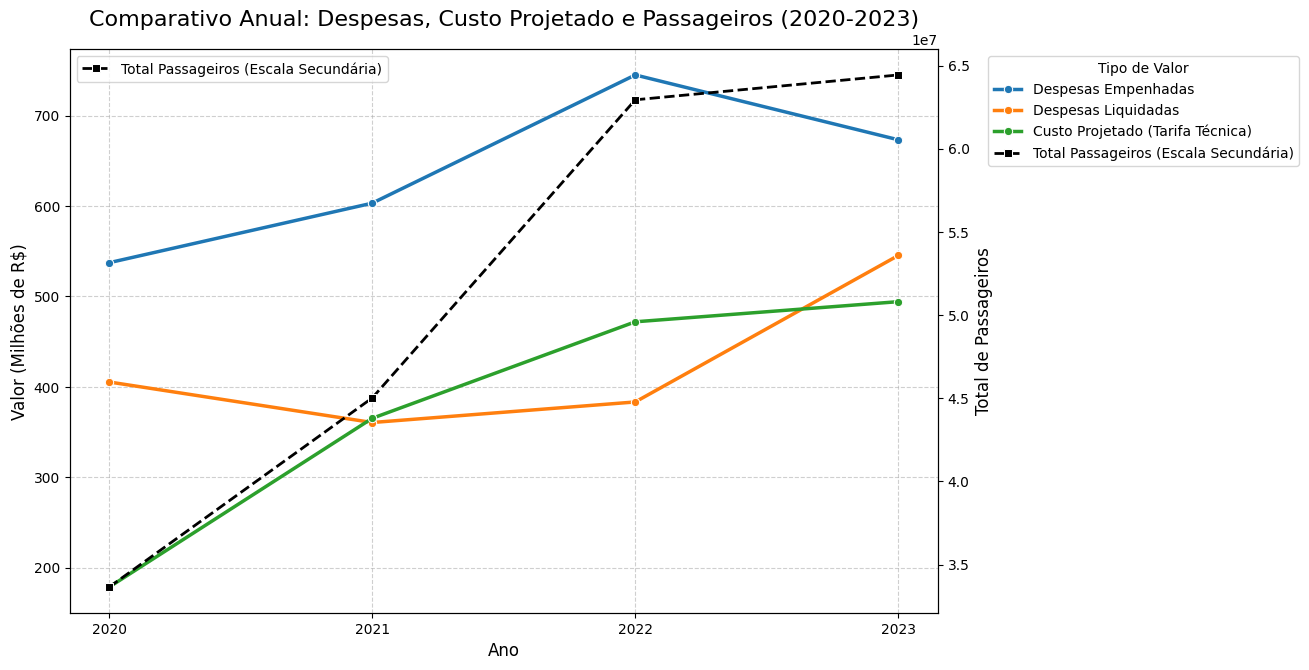

In [204]:
# --- GRÁFICO COMPARATIVO: DESPESAS, CUSTO PROJETADO (TARIFA TÉCNICA) E PASSAGEIROS ---
print("--- Gerando Gráfico Comparativo ---")

# Usar o DataFrame final consolidado
df_plot_data = df_final_anual.copy()

# 1. Reestruturar o DataFrame para o formato longo (melt)
# Incluímos as colunas de despesas, custo anual projetado com tarifa técnica e total de passageiros
df_plot_final = df_plot_data.melt(
    id_vars='ANO',
    value_vars=['Despesas_Empenhadas_Anual', 'Despesas_Liquidadas_Anual', 'CUSTO_ANUAL_MILHOES', 'TOTAL_PASSAGEIROS_ANUAL'], # Corrected column name
    var_name='Tipo de Valor',
    value_name='Valor'
)

# 2. Mapear nomes das colunas originais para rótulos amigáveis no gráfico
df_plot_final['Tipo de Valor'] = df_plot_final['Tipo de Valor'].map({
    'Despesas_Empenhadas_Anual': 'Despesas Empenhadas',
    'Despesas_Liquidadas_Anual': 'Despesas Liquidadas',
    'CUSTO_ANUAL_MILHOES': 'Custo Projetado (Tarifa Técnica)',
    'TOTAL_PASSAGEIROS_ANUAL': 'Total Passageiros (Escala Secundária)' # Corrected column name
})

# Para plotar passageiros em um eixo secundário, precisamos separar os dados para o plot
df_plot_despesas_custo = df_plot_final[df_plot_final['Tipo de Valor'].isin(['Despesas Empenhadas', 'Despesas Liquidadas', 'Custo Projetado (Tarifa Técnica)'])].copy()
df_plot_passageiros = df_plot_final[df_plot_final['Tipo de Valor'] == 'Total Passageiros (Escala Secundária)'].copy()

# Converter a coluna 'Valor' para numérico, caso haja algum problema (já deveria ser float)
df_plot_despesas_custo['Valor'] = pd.to_numeric(df_plot_despesas_custo['Valor'], errors='coerce')
df_plot_passageiros['Valor'] = pd.to_numeric(df_plot_passageiros['Valor'], errors='coerce')

# Remover linhas com valores NaN na coluna 'Valor' antes de plotar
df_plot_despesas_custo = df_plot_despesas_custo.dropna(subset=['Valor'])
df_plot_passageiros = df_plot_passageiros.dropna(subset=['Valor'])


# 3. Criar o gráfico com eixo secundário
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotar Despesas e Custo Projetado no eixo primário (ax1)
sns.lineplot(data=df_plot_despesas_custo, x="ANO", y="Valor", hue="Tipo de Valor", marker='o', ax=ax1, palette='tab10', linewidth=2.5)

# Configurar eixo primário
ax1.set_title('Comparativo Anual: Despesas, Custo Projetado e Passageiros (2020-2023)', fontsize=16)
ax1.set_xlabel('Ano', fontsize=12)
ax1.set_ylabel('Valor (Milhões de R$)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xticks(df_plot_final['ANO'].unique()) # Garante que todos os anos sejam exibidos no eixo X
ax1.tick_params(axis='y')


# Criar um eixo secundário para o total de passageiros (ax2)
# Multiplicamos a escala do eixo passageiro para caber no gráfico
ax2 = ax1.twinx()
sns.lineplot(data=df_plot_passageiros, x="ANO", y="Valor", marker='s', ax=ax2, color='black', linestyle='--', label='Total Passageiros (Escala Secundária)', linewidth=2)

# Configurar eixo secundário
ax2.set_ylabel('Total de Passageiros', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_yscale('linear') # Garantir escala linear, não log

# Adicionar legendas dos dois eixos
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), title='Tipo de Valor')


plt.tight_layout(rect=[0, 0.03, 0.95, 0.98]) # Ajusta o layout para a legenda não cortar
plt.show()

plt.style.use('default')

### 4.5 - Análise do Subsídio Governamental à URBS (2020-2023)

A URBS é uma empresa municipal de economia mista, regida pela lei das sociedades anônimas. Nesta seção, calcularemos o subsídio governamental necessário para cobrir seus gastos.

Os dados para esta análise, referentes ao período de 2020 a 2023, foram obtidos no painel interativo da URBS, disponível em: [https://lookerstudio.google.com/embed/u/0/reporting/b1ccd1b5-f21a-4374-af10-bc03226b3273/page/c6jRB](https://lookerstudio.google.com/embed/u/0/reporting/b1ccd1b5-f21a-4374-af10-bc03226b3273/page/c6jRB).

A escolha deste período (2020-2023) se deve à disponibilidade dos dados de despesas (Despesas_Empenhadas_Anual, Despesas_Liquidadas_Anual), total de passageiros (TOTAL_PASSAGEIROS_ANUAL), tarifa técnica (TARIFA_TECNICA) e custo anual projetado com base na tarifa técnica (CUSTO_ANUAL_MILHOES).

#### 4.5.1 - Ano de 2020

In [205]:
df_passageiros_2020 = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/Passageiro_P%C3%BAblico_2020.csv'
df_passageiros_2020 = pd.read_csv(df_passageiros_2020)
# Carrega o arquivo CSV de passageiros de 2020
df_passageiros_2020

,DATA,TOTAL S/ ISENTOS,Passageiros Isentos
0,1 de mar. de 2020,117109,27918
1,2 de mar. de 2020,615010,100508
2,3 de mar. de 2020,630057,102958
3,4 de mar. de 2020,639283,109205
4,5 de mar. de 2020,640561,106268
...,...,...,...
301,27 de dez. de 2020,47275,10471
302,28 de dez. de 2020,240975,35173
303,29 de dez. de 2020,240532,35095
304,30 de dez. de 2020,230682,36222


In [206]:
# Processa os dados de passageiros de 2020 (df_passageiros_2020)

# Verifica se o DataFrame foi lido como uma única coluna
if len(df_passageiros_2020.columns) == 1:
    nome_coluna = df_passageiros_2020.columns[0]
    df_passageiros_2020[['DATA', 'TOTAL S/ ISENTOS', 'Passageiros Isentos']] = df_passageiros_2020[nome_coluna].str.split(',', expand=True)

# Converte as novas colunas para os tipos de dados apropriados
df_passageiros_2020['TOTAL S/ ISENTOS'] = pd.to_numeric(df_passageiros_2020['TOTAL S/ ISENTOS'], errors='coerce')
df_passageiros_2020['Passageiros Isentos'] = pd.to_numeric(df_passageiros_2020['Passageiros Isentos'], errors='coerce')


# Converte a coluna 'DATA' para o formato datetime em df_passageiros_2020
# Usa a string de formato correta '%d de %b. de %Y' com base na prévia dos dados
df_passageiros_2020['DATA'] = pd.to_datetime(df_passageiros_2020['DATA'], format='%d de %b. de %Y', errors='coerce')

# Remove linhas onde a conversão de data falhou
df_passageiros_2020_cleaned = df_passageiros_2020.dropna(subset=['DATA']).copy()

# Extrai o ano da coluna 'DATA'
df_passageiros_2020_cleaned['ANO'] = df_passageiros_2020_cleaned['DATA'].dt.year

# Agrupa pelo 'ANO' extraído e soma as colunas de passageiros
df_passageiros_2020_anual = df_passageiros_2020_cleaned.groupby('ANO')[['TOTAL S/ ISENTOS', 'Passageiros Isentos']].sum().reset_index()

# Exibe o resultado
print("Dados Anuais de Passageiros para 2020:")
display(df_passageiros_2020_anual)

Dados Anuais de Passageiros para 2020:


,ANO,TOTAL S/ ISENTOS,Passageiros Isentos
0,2020,29387901,4253986


In [207]:
df_passageiros_2020_anual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   ANO                  1 non-null      int32
 1   TOTAL S/ ISENTOS     1 non-null      int64
 2   Passageiros Isentos  1 non-null      int64
dtypes: int32(1), int64(2)
memory usage: 152.0 bytes


#### 4.5.2 - Ano de 2021

In [208]:
file_path_passageiros_2021 = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/Passageiro_P%C3%BAblico_2021.csv'
df_passageiros_2021 = pd.read_csv(file_path_passageiros_2021)
# Carrega o arquivo CSV de passageiros de 2021
df_passageiros_2021

,DATA,TOTAL S/ ISENTOS,Passageiros Isentos
0,1 de jan. de 2021,33575,8703
1,2 de jan. de 2021,95419,16489
2,3 de jan. de 2021,46325,11299
3,4 de jan. de 2021,271733,42414
4,5 de jan. de 2021,280883,42546
...,...,...,...
360,27 de dez. de 2021,293200,41255
361,28 de dez. de 2021,306660,45943
362,29 de dez. de 2021,292396,44856
363,30 de dez. de 2021,249297,36483


In [209]:
df_passageiros_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DATA                 365 non-null    object
 1   TOTAL S/ ISENTOS     365 non-null    int64 
 2   Passageiros Isentos  365 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.7+ KB


In [210]:
# Processa os dados de passageiros de 2021 (df_passageiros_2021)

# --- Analisando a coluna única em múltiplas colunas (assumindo estrutura similar aos dados de 2020) ---
# Verifica se o DataFrame foi lido como uma única coluna
if len(df_passageiros_2021.columns) == 1:
    single_column_name = df_passageiros_2021.columns[0]
    df_passageiros_2021[['DATA', 'TOTAL S/ ISENTOS', 'Passageiros Isentos']] = df_passageiros_2021[single_column_name].str.split(',', expand=True)

# Converte as novas colunas para os tipos de dados apropriados
df_passageiros_2021['TOTAL S/ ISENTOS'] = pd.to_numeric(df_passageiros_2021['TOTAL S/ ISENTOS'], errors='coerce')
df_passageiros_2021['Passageiros Isentos'] = pd.to_numeric(df_passageiros_2021['Passageiros Isentos'], errors='coerce')


# Converte a coluna 'DATA' para o formato datetime em df_passageiros_2021
# Usa a string de formato correta '%d de %b. de %Y' com base na prévia dos dados
df_passageiros_2021['DATA'] = pd.to_datetime(df_passageiros_2021['DATA'], format='%d de %b. de %Y', errors='coerce')

# Remove linhas onde a conversão de data falhou
df_passageiros_2021_cleaned = df_passageiros_2021.dropna(subset=['DATA']).copy()

# Extrai o ano da coluna 'DATA'
df_passageiros_2021_cleaned['ANO'] = df_passageiros_2021_cleaned['DATA'].dt.year

# Agrupa pelo 'ANO' extraído e soma as colunas de passageiros
df_passageiros_2021_anual = df_passageiros_2021_cleaned.groupby('ANO')[['TOTAL S/ ISENTOS', 'Passageiros Isentos']].sum().reset_index()

# Exibe o resultado
print("Dados Anuais de Passageiros para 2021:")
display(df_passageiros_2021_anual)

Dados Anuais de Passageiros para 2021:


,ANO,TOTAL S/ ISENTOS,Passageiros Isentos
0,2021,39496818,5515022


#### 4.5.3 - Ano de 2022


In [211]:
file_path_passageiros_2022 = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/Passageiro_P%C3%BAblico_2022.csv'
df_passageiros_2022 = pd.read_csv(file_path_passageiros_2022)
# Carrega o arquivo CSV de passageiros de 2021
df_passageiros_2022

,DATA,TOTAL S/ ISENTOS,Passageiros Isentos
0,1 de jan. de 2022,47815,10860
1,2 de jan. de 2022,81396,15644
2,3 de jan. de 2022,305389,47506
3,4 de jan. de 2022,326195,51475
4,5 de jan. de 2022,344791,55722
...,...,...,...
360,27 de dez. de 2022,319675,52369
361,28 de dez. de 2022,314557,55247
362,29 de dez. de 2022,310112,52145
363,30 de dez. de 2022,266489,47849


In [212]:
df_passageiros_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DATA                 365 non-null    object
 1   TOTAL S/ ISENTOS     365 non-null    int64 
 2   Passageiros Isentos  365 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.7+ KB


In [213]:
# Processa os dados de passageiros de 2022 (df_passageiros_2022)

# --- Análise antes do processamento ---
# Verifica se o DataFrame foi lido como uma única coluna (assumindo estrutura similar aos dados de 2020)
if len(df_passageiros_2022.columns) == 1:
    coluna_unica = df_passageiros_2022.columns[0]
    df_passageiros_2022[['DATA', 'TOTAL S/ ISENTOS', 'Passageiros Isentos']] = df_passageiros_2022[coluna_unica].str.split(',', expand=True)

# Converte as novas colunas para os tipos de dados apropriados
df_passageiros_2022['TOTAL S/ ISENTOS'] = pd.to_numeric(df_passageiros_2022['TOTAL S/ ISENTOS'], errors='coerce')
df_passageiros_2022['Passageiros Isentos'] = pd.to_numeric(df_passageiros_2022['Passageiros Isentos'], errors='coerce')


# Converte a coluna 'DATA' para o formato datetime em df_passageiros_2022
# Usa a string de formato correta '%d de %b. de %Y' com base na prévia dos dados
df_passageiros_2022['DATA'] = pd.to_datetime(df_passageiros_2022['DATA'], format='%d de %b. de %Y', errors='coerce')

# Remove linhas onde a conversão de data falhou
df_passageiros_2022_cleaned = df_passageiros_2022.dropna(subset=['DATA']).copy()

# Extrai o ano da coluna 'DATA'
df_passageiros_2022_cleaned['ANO'] = df_passageiros_2022_cleaned['DATA'].dt.year

# Agrupa pelo 'ANO' extraído e soma as colunas de passageiros
df_passageiros_2022_anual = df_passageiros_2022_cleaned.groupby('ANO')[['TOTAL S/ ISENTOS', 'Passageiros Isentos']].sum().reset_index()

# Exibe o resultado
print("Dados Anuais de Passageiros para 2022:")
display(df_passageiros_2022_anual)

Dados Anuais de Passageiros para 2022:


,ANO,TOTAL S/ ISENTOS,Passageiros Isentos
0,2022,54891526,8046693


#### 4.5.4 - Ano de 2023


In [214]:
file_path_passageiros_2023 = 'https://raw.githubusercontent.com/lelenzasan/Projeto_Tarifa_Zero_Curitiba/main/data/Passageiro_P%C3%BAblico_2023.csv'
df_passageiros_2023 = pd.read_csv(file_path_passageiros_2023)
# Carrega o arquivo CSV de passageiros de 2023
df_passageiros_2023

,DATA,TOTAL S/ ISENTOS,Passageiros Isentos
0,1 de jan. de 2023,50465,12502
1,2 de jan. de 2023,271999,47219
2,3 de jan. de 2023,339696,59902
3,4 de jan. de 2023,312378,45335
4,5 de jan. de 2023,366212,67030
...,...,...,...
357,27 de dez. de 2023,313835,66308
358,28 de dez. de 2023,306805,61030
359,29 de dez. de 2023,274618,57379
360,30 de dez. de 2023,154776,37134


In [215]:
df_passageiros_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DATA                 362 non-null    object
 1   TOTAL S/ ISENTOS     362 non-null    int64 
 2   Passageiros Isentos  362 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.6+ KB


In [216]:
# Processa os dados de passageiros de 2023 (df_passageiros_2023)

# Converte a coluna 'DATA' para o formato datetime em df_passageiros_2023
# Usa a string de formato correta '%d de %b. de %Y' com base na prévia dos dados
df_passageiros_2023['DATA'] = pd.to_datetime(df_passageiros_2023['DATA'], format='%d de %b. de %Y', errors='coerce')

# Remove linhas onde a conversão de data falhou
df_passageiros_2023_cleaned = df_passageiros_2023.dropna(subset=['DATA']).copy()

# Extrai o ano da coluna 'DATA'
df_passageiros_2023_cleaned['ANO'] = df_passageiros_2023_cleaned['DATA'].dt.year

# Agrupa pelo 'ANO' extraído e soma as colunas de passageiros
df_passageiros_2023_anual = df_passageiros_2023_cleaned.groupby('ANO')[['TOTAL S/ ISENTOS', 'Passageiros Isentos']].sum().reset_index()

# Exibe o resultado
print("Dados Anuais de Passageiros para 2023:")
display(df_passageiros_2023_anual)

Dados Anuais de Passageiros para 2023:


,ANO,TOTAL S/ ISENTOS,Passageiros Isentos
0,2023,55047471,9385105


#### 4.5.5 - Juntando as tabelas...

In [217]:
# Consolida os dados anuais de passageiros dos dataframes individuais de cada ano

# Lista de dataframes anuais de passageiros
passageiros_anual_dfs = [
    df_passageiros_2020_anual,
    df_passageiros_2021_anual,
    df_passageiros_2022_anual,
    df_passageiros_2023_anual
]

# Concatena os dataframes
df_passageiros_anual_consolidados = pd.concat(passageiros_anual_dfs, ignore_index=True)

# Calcula o total anual de passageiros
df_passageiros_anual_consolidados['TOTAL_PASSAGEIROS_ANUAL'] = df_passageiros_anual_consolidados['TOTAL S/ ISENTOS'] + df_passageiros_anual_consolidados['Passageiros Isentos']

# Seleciona e renomeia colunas para corresponder ao formato necessário para o cálculo do subsídio
df_anual_passageiros_para_merge = df_passageiros_anual_consolidados[['ANO', 'TOTAL_PASSAGEIROS_ANUAL', 'Passageiros Isentos']].copy()
df_anual_passageiros_para_merge.rename(columns={'Passageiros Isentos': 'TOTAL_ISENTOS_ANUAL'}, inplace=True)


# Exibe os dados anuais consolidados de passageiros
print("Dados Anuais Consolidados de Passageiros (2020-2023):")
display(df_anual_passageiros_para_merge)

Dados Anuais Consolidados de Passageiros (2020-2023):


,ANO,TOTAL_PASSAGEIROS_ANUAL,TOTAL_ISENTOS_ANUAL
0,2020,33641887,4253986
1,2021,45011840,5515022
2,2022,62938219,8046693
3,2023,64432576,9385105


In [218]:
df_anual_passageiros_para_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   ANO                      4 non-null      int32
 1   TOTAL_PASSAGEIROS_ANUAL  4 non-null      int64
 2   TOTAL_ISENTOS_ANUAL      4 non-null      int64
dtypes: int32(1), int64(2)
memory usage: 212.0 bytes


#### 4.5.6 - Gerando o gráfico

--- Estimando o Subsídio Anual Necessário ---

Estimativa de Subsídio Anual Necessário (Milhões de R$):


,ANO,TOTAL_PASSAGEIROS_ANUAL,TOTAL_ISENTOS_ANUAL,TOTAL_PAGANTES_ANUAL_ESTIMADO,TARIFA_TECNICA,Despesas_Liquidadas_Anual,RECEITA_ESTIMADA_ANUAL,SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL_MILHOES
0,2020,33641887,4253986,29387901,5.3044,405.406387,1.558852e+08,249.521205
1,2021,45011840,5515022,39496818,8.1132,360.548937,3.204456e+08,40.103353
2,2022,62938219,8046693,54891526,7.4991,383.304745,4.116370e+08,-28.332298
3,2023,64432576,9385105,55047471,7.6709,545.389869,4.222636e+08,123.126223


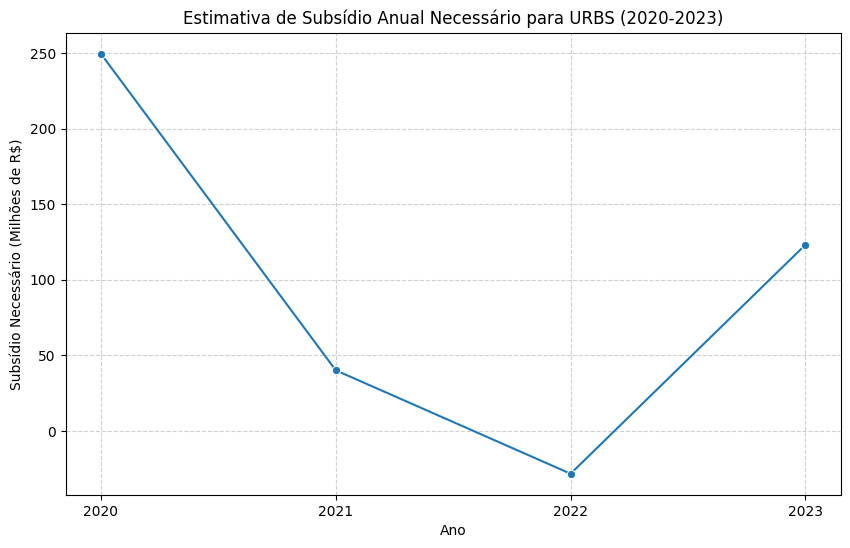

In [219]:
print("--- Estimando o Subsídio Anual Necessário ---")


# Juntar os DataFrames anuais
# df_anual_passageiros_para_merge tem 'ANO', 'TOTAL_PASSAGEIROS_ANUAL', 'TOTAL_ISENTOS_ANUAL'
df_subsidio_calc = pd.merge(df_anual_passageiros_para_merge, df_tarifa_anual, on='ANO', how='inner')
df_subsidio_calc = pd.merge(df_subsidio_calc, df_despesas_anual[['ANO', 'Despesas_Liquidadas_Anual']], on='ANO', how='inner')

# Preencher valores NaN com 0 após a junção, para cálculos
df_subsidio_calc = df_subsidio_calc.fillna(0)

# Calcular Passageiros Pagantes Anuais (Estimativa)
# TOTAL_PASSAGEIROS_ANUAL inclui isentos, então subtraímos os isentos para estimar pagantes
df_subsidio_calc['TOTAL_PAGANTES_ANUAL_ESTIMADO'] = df_subsidio_calc['TOTAL_PASSAGEIROS_ANUAL'] - df_subsidio_calc['TOTAL_ISENTOS_ANUAL']

# Calcular Receita Anual Estimada (apenas de passageiros pagantes)
# Usamos a tarifa técnica como proxy para a receita por passageiro pagante
df_subsidio_calc['RECEITA_ESTIMADA_ANUAL'] = df_subsidio_calc['TOTAL_PAGANTES_ANUAL_ESTIMADO'] * df_subsidio_calc['TARIFA_TECNICA']

# O subsídio necessário é a diferença entre as Despesas Liquidadas (custo real pago pelo governo)
# e a Receita Estimada dos pagantes.
# Se as despesas liquidadas forem maiores que a receita, há um subsídio.
# Convertendo Despesas_Liquidadas_Anual de milhões para unidades
df_subsidio_calc['Despesas_Liquidadas_Anual_Unidades'] = df_subsidio_calc['Despesas_Liquidadas_Anual'] * 1000000

df_subsidio_calc['SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL'] = df_subsidio_calc['Despesas_Liquidadas_Anual_Unidades'] - df_subsidio_calc['RECEITA_ESTIMADA_ANUAL']

# Convertendo o subsídio para milhões para melhor visualização
df_subsidio_calc['SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL_MILHOES'] = df_subsidio_calc['SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL'] / 1000000

# Ordenar por ano para melhor legibilidade
df_subsidio_calc = df_subsidio_calc.sort_values(by='ANO').reset_index(drop=True)

# Exibir os resultados
print("\nEstimativa de Subsídio Anual Necessário (Milhões de R$):")
display(df_subsidio_calc[['ANO', 'TOTAL_PASSAGEIROS_ANUAL', 'TOTAL_ISENTOS_ANUAL', 'TOTAL_PAGANTES_ANUAL_ESTIMADO', 'TARIFA_TECNICA', 'Despesas_Liquidadas_Anual', 'RECEITA_ESTIMADA_ANUAL', 'SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL_MILHOES']])

# Você pode opcionalmente plotar o subsídio ao longo dos anos
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_subsidio_calc, x='ANO', y='SUBSIDIO_NECESSARIO_ESTIMADO_ANUAL_MILHOES', marker='o')
plt.title('Estimativa de Subsídio Anual Necessário para URBS (2020-2023)')
plt.xlabel('Ano')
plt.ylabel('Subsídio Necessário (Milhões de R$)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_subsidio_calc['ANO'])
plt.show()